In [1]:
!pip install yfinance

     |████████████████████████████████| 4.6 MB 2.4 MB/s eta 0:00:01
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=e7cb7670928e6f8a5f0c3764f36859331695f7d4266ec3b1fa34e1716bc1acfd
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/68/72/87/a384b8b8139f2489024464d6f5937e6acb2054c57d25519fb9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8367 sha256=c3ed619b5b269bd6d0ecb7c3e57a4efd06c64b6b194cea6396cec0bbcff3f48a
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/5e/8a/c4/59c699498647c7c94b14c87a904ca7540646107b3d94b7c320
Successfully built yfinance multitasking
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.5
    Uninstalling lxml-4.2.5:
      Successfully uninstalled lxml-4.2.5


In [2]:
import yfinance as yf

msft = yf.Ticker("MSFT")

# get stock info
msft.info

# get historical market data
hist = msft.history(period="max")

In [3]:
# later we'll use this one:
!pip install -U pymc3

     |████████████████████████████████| 1.9 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 38.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.8 MB 9.7 MB/s eta 0:00:01     |██████████████████████████▌     | 2.4 MB 9.7 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 720 kB 6.4 MB/s eta 0:00:01
  Created wheel for contextvars: filename=contextvars-2.4-py3-none-any.whl size=7665 sha256=5f2aa42525589b38513544967bb4af4c07203e01ccca9f6e7c45de7ae9040d74
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/41/11/53/911724983aa48deb94792432e14e518447212dd6c5477d49d3
  Created wheel for theano: filename=Theano-1.0.5-py3-none-any.whl size=2668095 sha256=ae96e21415933c8228c88bced1d95da4321d1145f199c69b70da53171dce1429
  Stored in directory: /Users/ben/Library/Caches/pip/wheels/7f/80/57/2970ddd2e4961d84fb0d58196f4965deead046d29e08693e73
Successfully built contextvars theano
  Atte

In [4]:
# ... and this one, based on the previous:
!pip install pymc-learn

In [13]:
import os
#os.environ['THEANO_FLAGS'] = 'contexts=dev0->cuda0;dev1->cuda1'
import theano
# if you get a warning about pygpu imports, 
# you might have to install a different version of pygpu,
# and restart the notebook. For example:
# !pip install pygpu==0.7.6

In [14]:
from typing import Tuple
import numpy as np
import pandas as pd
import scipy


def generate_data(
    data: pd.DataFrame, window_size: int, shift: int
) -> Tuple[np.array, np.array]:
    '''Generates data, X and y, based on stock price
    history given a window_size and a shift.
    
    The price level is extracted over a window, a
    period of days, Finally, a day, shift days later,
    is to be compared against.    

    Parameters:
    -----------
    data - stock prices over time
    window_size - window size; how many days in X
    shift - which point to extract as y? This is
        taken with respect to the last point in X.
    
    Returns:
    --------
    X - history of stock prices with their window
    y - the stock prices in the future to be predicted
    
    X - Windows are normalized to mean 0 and then 
    differenced (each value in a window to the 
    previous values) - as percentage change. The
    differencing step is to introduce a measure of 
    stationarity. 
    
    y - as percentage change with respect to the
    last value in the window.    
    
    This is to help to answer the following question:
    Given the level of prices, are they going to
    rise or to fall, and how much?    
    '''
    y = data.shift(shift + window_size)
    observation_window = []
    for i in range(window_size):
        observation_window.append(
            data.shift(i)
        )
    X = pd.concat(observation_window, axis=1)
    y = (y - X.values[:, -1]) / X.values[:, -1]
    X = X.pct_change(axis=1).values[:, 1:]
    inds = (~np. isnan(X).any(axis=1)) & (~np. isnan(y))
    X, y = X[inds], y[inds]
    return X, y

In [15]:
from sklearn.model_selection import train_test_split

X, y = generate_data(hist.Close, shift=1, window_size=30)
X_train, X_test, y_train, y_test = train_test_split(X, y)


#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

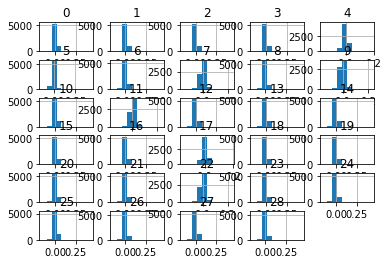

In [16]:
pd.DataFrame(X_train).hist();

In [17]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'values')

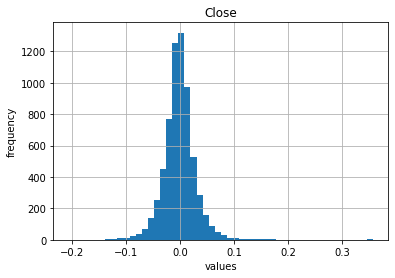

In [18]:
pd.DataFrame(y_train).hist(bins=50)
plt.ylabel('frequency')
plt.xlabel('values')

In [19]:
(y > 0).mean()

0.4636980784719825

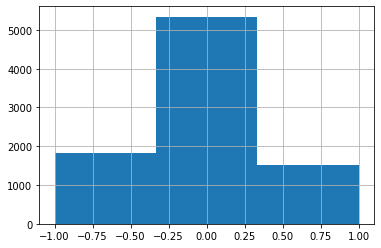

In [21]:
def threshold_vector(x, threshold=0.02):
    def threshold_scalar(f):
        if f > threshold:
            return 1
        elif f < -threshold:
            return -1
        return 0
    return np.vectorize(threshold_scalar)(x)

y_train_classes, y_test_classes = threshold_vector(y_train), threshold_vector(y_test)
pd.Series(threshold_vector(y)).hist(bins=3)

In [22]:
import sklearn
import scipy


def to_one_hot(a, classes=[-1, 0, 1]):
    """convert from integer encoding to one-hot"""
    b = np.zeros((a.size, 3))
    b[np.arange(a.size), (np.rint(a)+1).astype(int)] = 1
    return b

def measure_perf(model, y_test):
    y_pred = model.predict(X_test)
    print('AUC: {:.3f}'.format(
        sklearn.metrics.roc_auc_score(
            to_one_hot(y_test), to_one_hot(y_pred), multi_class='ovo'
    )))
    print('mse pred: {}'.format(
        sklearn.metrics.mean_squared_error(y_test, y_pred)
    ))
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)
        y_pred_reg = np.average(
            np.repeat(
                np.array([-1, 0, 1]).reshape(1, -1),
                X_test.shape[0],
                axis=0
            ),
            axis=1,
            weights=y_pred_proba
        )    
        print('mse prob: {}'.format(
            sklearn.metrics.mean_squared_error(y_test, y_pred_reg)
        ))
        

assert to_one_hot(y_test_classes.astype(int)).shape[1] == 3

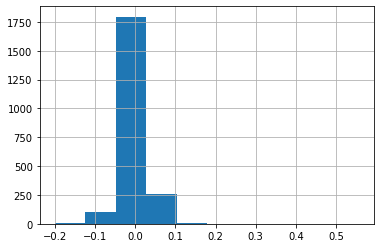

In [24]:
pd.Series(y_test).hist();

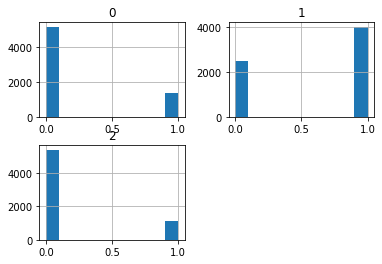

In [26]:
pd.DataFrame(to_one_hot(y_train_classes)).hist();

In [28]:
from sklearn.ensemble import StackingClassifier, StackingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, CategoricalNB
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import BayesianRidge, LinearRegression, LogisticRegression
from imblearn.pipeline import make_pipeline

# see also the naivebayes-predictor library that implements a wider range of supported distribution than what comes with sklearn's implementation

def create_classifier(final_estimator):
    print(f'{final_estimator.__class__.__name__}:')
    if final_estimator._estimator_type == 'regressor':
        estimators = [
            ('rf', RandomForestRegressor(
                n_estimators=100,
                n_jobs=-1
            ))
        ]        
        return StackingRegressor(
            estimators=estimators,
            final_estimator=final_estimator,
        ).fit(X_train, y_train_classes)
    else:
        estimators = [
            ('rf', RandomForestClassifier(
                n_estimators=100,
                n_jobs=-1
            ))
        ]                
        return StackingClassifier(
            estimators=estimators,
            final_estimator=final_estimator,
            #stack_method='predict_proba'
        ).fit(X_train, y_train_classes)

measure_perf(create_classifier(ComplementNB()), y_test_classes)
measure_perf(create_classifier(CategoricalNB()), y_test_classes)
measure_perf(create_classifier(BayesianRidge()), y_test_classes)
measure_perf(create_classifier(LinearRegression()), y_test_classes)

ComplementNB:
AUC: 0.573
mse pred: 0.9378739070409572
mse prob: 0.39530602670232257
CategoricalNB:
AUC: 0.500
mse pred: 0.39530602853198343
mse prob: 0.3938523388872352
BayesianRidge:
AUC: 0.500
mse pred: 0.39518368709305485
LinearRegression:
AUC: 0.500
mse pred: 0.3945542718626845


In [29]:
from sklearn.calibration import CalibratedClassifierCV

rf = RandomForestClassifier(n_estimators=500, n_jobs=-1).fit(X_train, y_train_classes)
platt = CalibratedClassifierCV(rf, method='sigmoid').fit(X_train, y_train_classes)
isotonic = CalibratedClassifierCV(rf, method='isotonic').fit(X_train, y_train_classes)
measure_perf(platt, y_test_classes)
measure_perf(isotonic, y_test_classes)

AUC: 0.513
mse pred: 0.42291762540266914
mse prob: 0.3962276227874193
AUC: 0.517
mse pred: 0.43718361711919007
mse prob: 0.3956709350716044


In [30]:
measure_perf(rf, y_test_classes)

AUC: 0.518
mse pred: 0.4445467096180396
mse prob: 0.3941700782328578


In [31]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
# see also the naivebayes-predictor library that implements a wider range of supported distribution than what comes with sklearn's implementation
estimators = [
    ('rf', RandomForestRegressor(n_estimators=500, n_jobs=-1)),
]
clf = StackingRegressor(
    estimators=estimators,
    final_estimator=BayesianRidge()
)
clf.fit(X_train, y_train)
measure_perf(clf, y_test_classes)

AUC: 0.500
mse pred: 0.3951464754864403
